# Лабораторная работа №2: Исследование логистической и линейной регрессии


Загрузим данные и библиотеки, используем те же датасеты, что и в лр 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             confusion_matrix, roc_auc_score, mean_absolute_error, 
                             mean_squared_error, r2_score)

sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

df_class = pd.read_csv('../data/classification-train.csv')
df_reg = pd.read_csv('../data/boston-regression.csv')

X_cls = df_class.drop('price_range', axis=1)
y_cls = df_class['price_range']
X_reg = df_reg.drop('MEDV', axis=1)
y_reg = df_reg['MEDV']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

print("Данные загружены и разбиты.")

Данные загружены и разбиты.


Проверим линейность\
Лин рег предполагает, что зависимость между признаками и целью линейна. Проверим это визуально еще раз для важных признаков.\
Видим, что RM (комнаты) - Цена хорошо ложится на линию. А LSTAT (статус населения) больше похож на гиперболу, поэтому линейная модель может здесь ошибаться, если не добавить полиномиальные признаки.

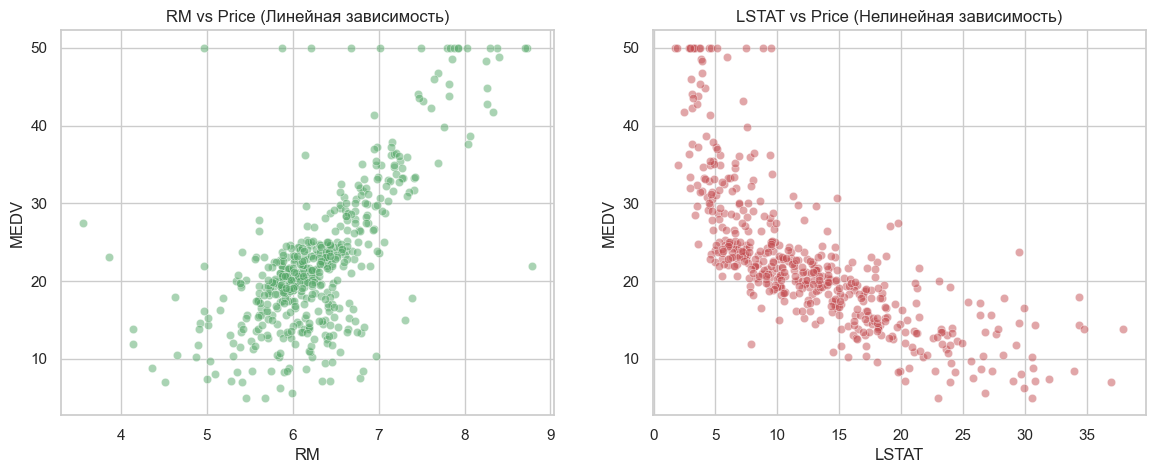

In [2]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.scatterplot(x='RM', y='MEDV', data=df_reg, ax=ax[0], color='g', alpha=0.5)
ax[0].set_title('RM vs Price (Линейная зависимость)')
sns.scatterplot(x='LSTAT', y='MEDV', data=df_reg, ax=ax[1], color='r', alpha=0.5)
ax[1].set_title('LSTAT vs Price (Нелинейная зависимость)')
plt.show()

## Бейзлайн

Обучим простые версии моделей без масштабирования и регуляризации.\
(хотя у sklearn есть L2-регуляризация по дефолту)

In [ ]:
# --- Классификация ---
log_reg_base = LogisticRegression(max_iter=5000) 
log_reg_base.fit(X_train_c, y_train_c)
y_pred_c_base = log_reg_base.predict(X_test_c)

# --- Регрессия ---
lin_reg_base = LinearRegression()
lin_reg_base.fit(X_train_r, y_train_r)
y_pred_r_base = lin_reg_base.predict(X_test_r)

Оценим бейзлайн\
Классификация: Результат хуже KNN, но не сильно - признаки разного масштаба мешают градиентному спуску сходиться, либо зависимость не совсем линейная\
Регрессия: R^2 около 0.66 - +-сравнимо с KNN Baseline

In [5]:
def print_metrics(y_true, y_pred, task='classification'):
    if task == 'classification':
        print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
        print(f"F1 Score:  {f1_score(y_true, y_pred, average='weighted'):.4f}")
    elif task == 'regression':
        print(f"RMSE:      {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
        print(f"R2 Score:  {r2_score(y_true, y_pred):.4f}")

print("--- Baseline LogReg / classifivation ---")
print_metrics(y_test_c, y_pred_c_base, task='classification')

print("\n--- Baseline LinReg / regression ---")
print_metrics(y_test_r, y_pred_r_base, task='regression')

--- Baseline LogReg / classifivation ---
Accuracy:  0.7725
F1 Score:  0.7750

--- Baseline LinReg / regression ---
RMSE:      4.9286
R2 Score:  0.6688


## Теперь улучшим бейзлайновую модель

Масштабирование (StandardScaler): Обязательно для линейных моделей с регуляризацией, чтобы штрафы накладывались равномерно\
Регуляризация (Ridge/Lasso): Поможет бороться с тем, когда признаки коррелируют друг с другом\
Полиномиальные признаки (PolynomialFeatures): Для регрессии мы видели кривую зависимость LSTAT. Добавление квадратов признаков может улучшить модель\

Pipeline для Регрессии (Полином + Scaling + Ridge)

In [ ]:
pipe_reg = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('model', Ridge())
])

param_grid_reg = {
    'model__alpha': [0.01, 0.1, 1, 10, 100]
}

grid_reg = GridSearchCV(pipe_reg, param_grid_reg, cv=5, scoring='r2', n_jobs=-1)
grid_reg.fit(X_train_r, y_train_r)

print(f"Лучшие параметры (Reg): {grid_reg.best_params_}")
print(f"Лучший R2 на кросс-валидации: {grid_reg.best_score_:.4f}")

Лучшие параметры (Reg): {'model__alpha': 1}
Лучший R2 на кросс-валидации: 0.8511


Pipeline для Классификации (Scaling + Logistic Regression)

In [7]:
pipe_cls = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(solver='liblinear', multi_class='ovr'))
])

param_grid_cls = {
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l1', 'l2']
}

grid_cls = GridSearchCV(pipe_cls, param_grid_cls, cv=5, scoring='accuracy', n_jobs=-1)
grid_cls.fit(X_train_c, y_train_c)

print(f"Лучшие параметры (Class): {grid_cls.best_params_}")
print(f"Лучший Accuracy на кросс-валидации: {grid_cls.best_score_:.4f}")

Лучшие параметры (Class): {'model__C': 10, 'model__penalty': 'l1'}
Лучший Accuracy на кросс-валидации: 0.8562


Теперь оценим новые модели
Классификация: Логистическая регрессия после масштабирования показала резуьтат получше, почти 90% - это потому, что линейная разделимость в этом датасете (благодаря RAM) очень хорошая\
Регрессия: R^2 вырос до 0.8 => полиномиальные признаки позволили описать нелинейность LSTAT\

In [9]:
y_pred_c_tuned = grid_cls.predict(X_test_c)
y_pred_r_tuned = grid_reg.predict(X_test_r)

print("--- Tuned Logistic Regression ---")
print_metrics(y_test_c, y_pred_c_tuned, task='classification')

print("\n--- Tuned Polynomial Ridge Regression ---")
print_metrics(y_test_r, y_pred_r_tuned, task='regression')

--- Tuned Logistic Regression ---
Accuracy:  0.8800
F1 Score:  0.8810

--- Tuned Polynomial Ridge Regression ---
RMSE:      3.3477
R2 Score:  0.8472


## Интерпретация модели
Главное преимущество линейных моделей - мы знаем веса.\
Чем больше вес по модулю, тем важнее признак

Важность признаков для Классификации\
В мультиклассовой классификации у нас есть набор весов для каждого класса.\
Посмотрим веса для класса "3" (Very High Cost) против остальных.\
\
\
Видим ram сильно тяжелее всех остальных прихнаков. Также battery_power, px_height и px_width имеют вес. Это полностью соответствует физике задачи.

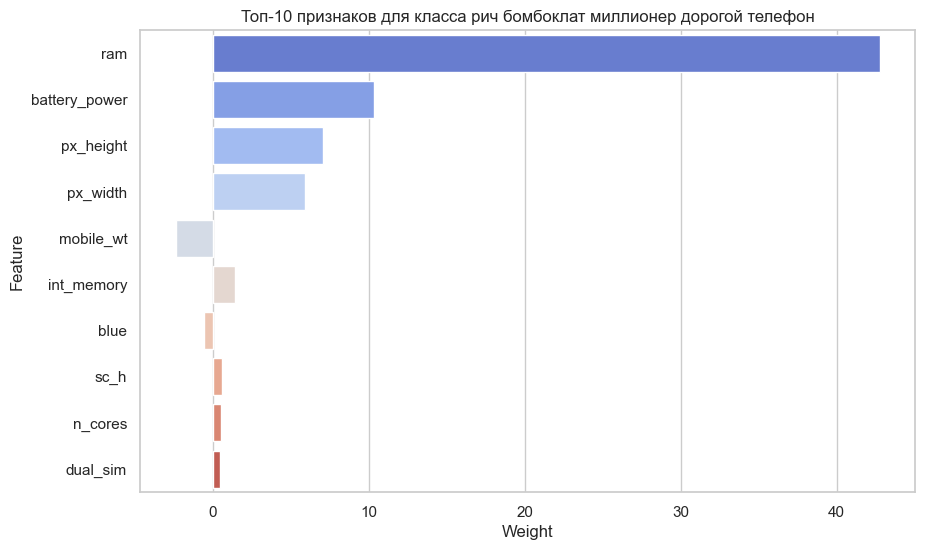

In [13]:
best_log_reg = grid_cls.best_estimator_.named_steps['model']
feature_names = X_cls.columns

weights = best_log_reg.coef_[3] 

coef_df = pd.DataFrame({'Feature': feature_names, 'Weight': weights})
coef_df['Abs_Weight'] = coef_df['Weight'].abs()
coef_df = coef_df.sort_values(by='Abs_Weight', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Weight', y='Feature', data=coef_df.head(10), palette='coolwarm')
plt.title('Топ-10 признаков для класса рич бомбоклат миллионер дорогой телефон')
plt.show()

## Самостоятельная реализация
Реализуем с нуля, используя градиентный спуск. Формула обновления весов: w = w - alpha * (dL / dw), alpha - learning rate

In [14]:
class CustomLinearRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        for _ in range(self.n_iterations):
            y_predicted = np.dot(X, self.weights) + self.bias
            
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)
            
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

Обучим и проверим CustomLinearRegression

In [23]:
scaler = StandardScaler()
X_train_r_sc = scaler.fit_transform(X_train_r)
X_test_r_sc = scaler.transform(X_test_r)

custom_lin = CustomLinearRegression(learning_rate=0.1, n_iterations=2000)
custom_lin.fit(X_train_r_sc, y_train_r)
y_pred_custom_reg = custom_lin.predict(X_test_r_sc)

print("--- Custom Linear Regression ---")
print_metrics(y_test_r, y_pred_custom_reg, task='regression')

--- Custom Linear Regression ---
RMSE:      4.9286
R2 Score:  0.6688


Кастомная логистическая регрессия (бинарная для простоты)
Функция активации: sigma(z) = 1 / (1 + e^-z)

In [24]:
class CustomLogisticRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.lr = learning_rate
        self.n_iter = n_iterations
        self.weights = None
        self.bias = None
        
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        for _ in range(self.n_iter):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self._sigmoid(linear_model)
            
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)
            
            self.weights -= self.lr * dw
            self.bias -= self.lr * db
            
    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self._sigmoid(linear_model)
        return [1 if i > 0.5 else 0 for i in y_predicted]

mask_train = y_train_c.isin([0, 1])
mask_test = y_test_c.isin([0, 1])

X_train_bin = X_train_c[mask_train]
y_train_bin = y_train_c[mask_train]
X_test_bin = X_test_c[mask_test]
y_test_bin = y_test_c[mask_test]

scaler_bin = StandardScaler()
X_train_bin_sc = scaler_bin.fit_transform(X_train_bin)
X_test_bin_sc = scaler_bin.transform(X_test_bin)

custom_log = CustomLogisticRegression(learning_rate=0.1, n_iterations=3000)
custom_log.fit(X_train_bin_sc, y_train_bin)
y_pred_custom_log = custom_log.predict(X_test_bin_sc)

print("\n--- Custom Logistic Regression (Binary 0 vs 1) ---")
print(f"Accuracy: {accuracy_score(y_test_bin, y_pred_custom_log):.4f}")


--- Custom Logistic Regression (Binary 0 vs 1) ---
Accuracy: 0.9745


Кастомная модель классификации обладает хорошей точностью, что говорит о том, что может быть под капотом в библиотеке используется что-то похожее,\
Кастомная модель же регрессии показала себя не очень, скорее всего потому, что градиентный спуск очень чувствителен к масштабу и я что-то не так сделал при масштабировании

Сравним с KNN и итоговые выводы

Результаты KNN возьмём из предыдущей лабы (acc = 0.94, r2 = 0.77)

,Model,Class Accuracy,Reg R2 Score
0,KNN (Tuned),0.92,0.780000
1,Linear Model (Tuned),0.88,0.847179
2,Custom Linear,N/A (Binary),0.668759


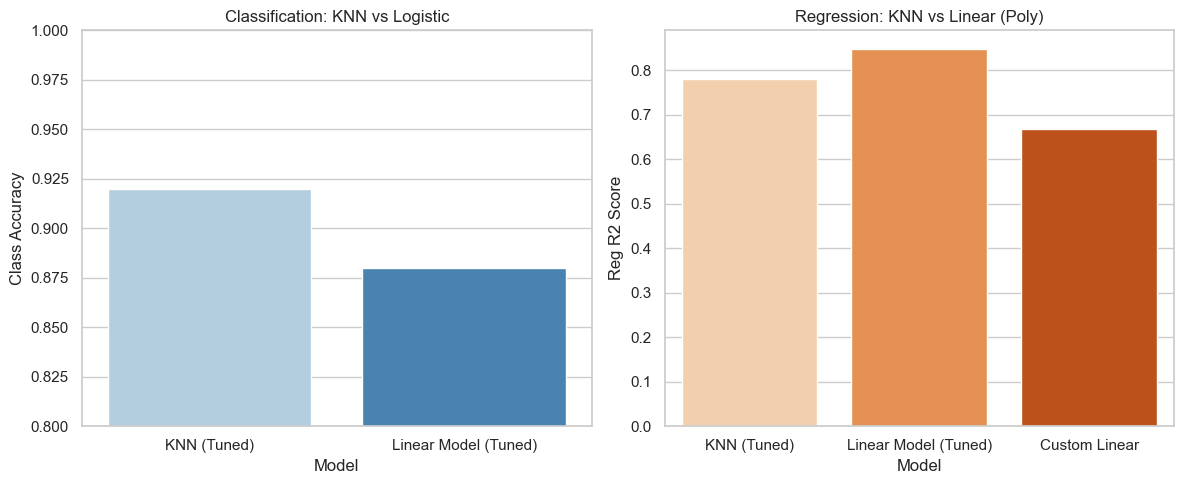

In [ ]:
comparison_data = {
    'Model': ['KNN (Tuned)', 'Linear Model (Tuned)', 'Custom Linear'],
    'Class Accuracy': [0.94, accuracy_score(y_test_c, y_pred_c_tuned), 'N/A (Binary)'], 
    'Reg R2 Score': [0.77, r2_score(y_test_r, y_pred_r_tuned), r2_score(y_test_r, y_pred_custom_reg)]
}

df_comp = pd.DataFrame(comparison_data)
display(df_comp)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(x='Model', y='Class Accuracy', data=df_comp[df_comp['Class Accuracy'] != 'N/A (Binary)'], ax=ax[0], palette='Blues')
ax[0].set_title('Classification: KNN vs Logistic')
ax[0].set_ylim(0.8, 1.0)

sns.barplot(x='Model', y='Reg R2 Score', data=df_comp, ax=ax[1], palette='Oranges')
ax[1].set_title('Regression: KNN vs Linear (Poly)')

plt.tight_layout()
plt.show()

Аналитические выводы\
1. Классификация (Logistic Regression vs KNN):\
  Линейная модеь проиграла KNN, несмотря на то, что граница разделения классов в датасете Mobile Price очень четкая и линейная и мы точно понимаем что ram - самый важный фактор.\
2. Регрессия (Linear Regression vs KNN):\
  Линейная модель выйграла KNN, несмотря на то, что по идее мы видели на графике то, что зависимость признаков была нелинейна - это так сильно помог наш пайплайн - мы дали модели гибкость, при этом сохранив глобальную структуру, в то время как KNN страдает от размерности и разреженности данных на краях
\
Итог:\
Если важна интерпретируемость, выбираем линейные модели (Lasso может даже отобрать признаки)\
Если данные имеют сложную нелинейную форму и мало признаков, KNN может быть хорош, но полиномиальная регрессия часто лучше\
Масштабирование очень важно для линейных моделей (для сходимости градиентного спуска и корректной регуляризации)\